In [140]:
from scipy.io import loadmat

In [141]:
data = loadmat("data/normal.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X097_DE_time', 'X097_FE_time', 'X097RPM'])

In [142]:
import os
os.getcwd()


'C:\\Users\\sudes\\gearbox-maintenance'

In [143]:
signal = data['X097_DE_time'].flatten()
len(signal)


243938

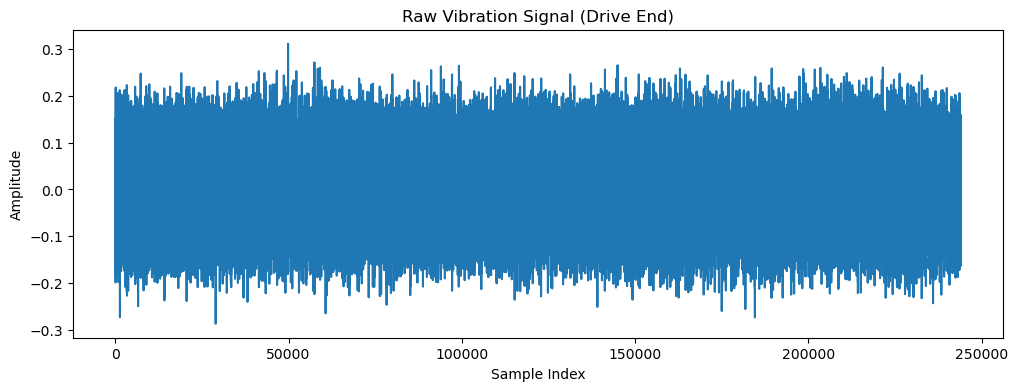

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title("Raw Vibration Signal (Drive End)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


In [145]:
import numpy as np

segment = signal[:10000]
rms = np.sqrt(np.mean(segment**2))
rms


0.0744438781235628

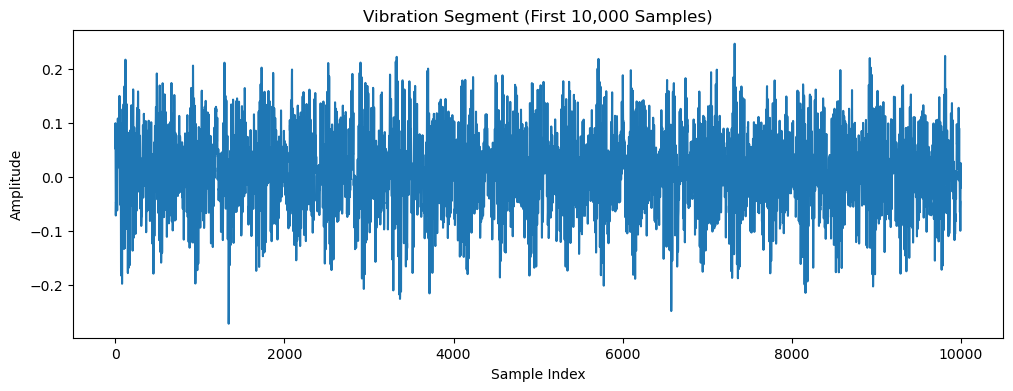

In [146]:
plt.figure(figsize=(12, 4))
plt.plot(segment)
plt.title("Vibration Segment (First 10,000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


In [147]:
from scipy.stats import kurtosis

kurt = kurtosis(segment)
kurt


-0.12152143445245

In [148]:
from scipy.io import loadmat

fault_data = loadmat("data/inner_fault.mat")
fault_data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'])

In [149]:
fault_signal = fault_data['X105_DE_time'].flatten()
len(fault_signal)


121265

In [150]:
fault_segment = fault_signal[:10000]



In [151]:
fault_rms = np.sqrt(np.mean(fault_segment ** 2))
fault_rms


0.28950003833384347

In [152]:
fault_kurt = kurtosis(fault_segment)
fault_kurt


2.577804236040751

In [153]:
from scipy.fft import fft


In [154]:
normal_fft = np.abs(fft(segment))
len(normal_fft)


10000

In [155]:
fault_fft = np.abs(fft(fault_segment))
len(fault_fft)


10000

In [156]:
normal_fft_energy = np.sum(normal_fft**2)
fault_fft_energy = np.sum(fault_fft**2)

print("normal_fft_energy =", normal_fft_energy)
print("fault_fft_energy  =", fault_fft_energy)


normal_fft_energy = 554189.0990075872
fault_fft_energy  = 8381027.219529685


In [157]:
import pandas as pd


In [158]:
data = {
    "rms": [normal_rms, fault_rms],
    "kurtosis": [normal_kurt, fault_kurt],
    "fft_energy": [normal_fft_energy, fault_fft_energy],
    "label": ["normal", "fault"]
}

df = pd.DataFrame(data)
df



,rms,kurtosis,fft_energy,label
0,0.074444,-0.121521,5.541891e+05,normal
1,0.289500,2.577804,8.381027e+06,fault


In [159]:
X = df[["rms", "kurtosis", "fft_energy"]]
y = df["label"]


In [160]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded


array([1, 0])

In [161]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)

model.fit(X, y_encoded)


RandomForestClassifier(n_estimators=50, random_state=42)

In [162]:
predictions = model.predict(X)
predictions


array([1, 0])

In [163]:
def extract_features(signal_segment):
    rms = np.sqrt(np.mean(signal_segment**2))
    kurt = kurtosis(signal_segment)
    fft_vals = np.abs(np.fft.fft(signal_segment))
    fft_energy = np.sum(fft_vals**2)
    
    return rms, kurt, fft_energy


In [164]:
features = []
labels = []


In [165]:
from scipy.io import loadmat

normal_data = loadmat("data/normal.mat")
normal_signal = normal_data['X097_DE_time'].flatten()


In [166]:
max_segments_normal = len(normal_signal) // segment_length
max_segments_fault  = len(fault_signal) // segment_length

max_segments_normal, max_segments_fault


(24, 12)

In [167]:
num_segments = min(max_segments_normal, max_segments_fault)
num_segments


12

In [168]:
def extract_features(signal_segment):
    # SAFETY CHECK
    if len(signal_segment) == 0:
        return None
    
    rms = np.sqrt(np.mean(signal_segment**2))
    kurt = kurtosis(signal_segment)
    fft_vals = np.abs(np.fft.fft(signal_segment))
    fft_energy = np.sum(fft_vals**2)
    
    return rms, kurt, fft_energy


In [169]:
features = []
labels = []


In [170]:
for i in range(num_segments):
    start = i * segment_length
    end = start + segment_length
    
    segment = normal_signal[start:end]
    result = extract_features(segment)
    
    if result is not None:
        rms, kurt, fft_energy = result
        features.append([rms, kurt, fft_energy])
        labels.append("normal")



In [171]:
for i in range(num_segments):
    start = i * segment_length
    end = start + segment_length
    
    segment = fault_signal[start:end]
    result = extract_features(segment)
    
    if result is not None:
        rms, kurt, fft_energy = result
        features.append([rms, kurt, fft_energy])
        labels.append("fault")


In [172]:
len(features), len(labels)


(24, 24)

In [173]:
import pandas as pd

df = pd.DataFrame(
    features,
    columns=["rms", "kurtosis", "fft_energy"]
)

df["label"] = labels

df.head()


,rms,kurtosis,fft_energy,label
0,0.074444,-0.121521,554189.099008,normal
1,0.073041,-0.273064,533494.953085,normal
2,0.073833,-0.223754,545132.949932,normal
3,0.072493,-0.276346,525526.279918,normal
4,0.074081,-0.119573,548796.295653,normal


In [174]:
df.tail()


,rms,kurtosis,fft_energy,label
19,0.294540,2.048004,8.675386e+06,fault
20,0.291834,2.370781,8.516728e+06,fault
21,0.291518,2.600466,8.498290e+06,fault
22,0.289577,2.582140,8.385462e+06,fault
23,0.292308,2.543469,8.544414e+06,fault


In [175]:
df["label"].value_counts()



label
normal    12
fault     12
Name: count, dtype: int64

In [176]:
X = df[["rms", "kurtosis", "fft_energy"]]
y = df["label"]


In [177]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded[:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)


In [179]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [180]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 1.0
              precision    recall  f1-score   support

       fault       1.00      1.00      1.00         4
      normal       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [181]:
print("Final Project Summary")
print("---------------------")
print("Total samples:", len(df))
print(df["label"].value_counts())
print("\nModel Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Final Project Summary
---------------------
Total samples: 24
label
normal    12
fault     12
Name: count, dtype: int64

Model Performance on Test Set:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

       fault       1.00      1.00      1.00         4
      normal       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

